In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [50]:
def show_image(window_name, image, cmap=None):
    if image is None:
        print(f"{window_name}: imagem nao carregada (None)")
        return

    if len(image.shape) == 3 and image.shape[2] == 3:
        img_disp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        img_disp = image
        if cmap is None:
            cmap = 'gray'
    plt.figure(figsize=(8, 6))
    plt.title(window_name)
    plt.axis('off')
    plt.imshow(img_disp, cmap=cmap)
    plt.show()

def close_all_windows():
    pass

In [51]:
MIN_AREA = 250
MAX_AREA = 1000

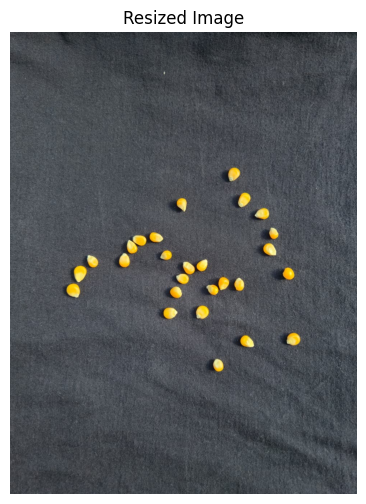

In [52]:
img = cv2.imread('imagens/agrupado1.jpg')
craped_img = img.copy()
# img = cv2.resize(img, (600, 800))
show_image("Resized Image", img)

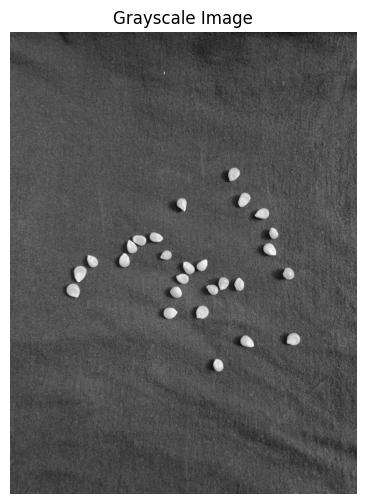

In [53]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image("Grayscale Image", gray)

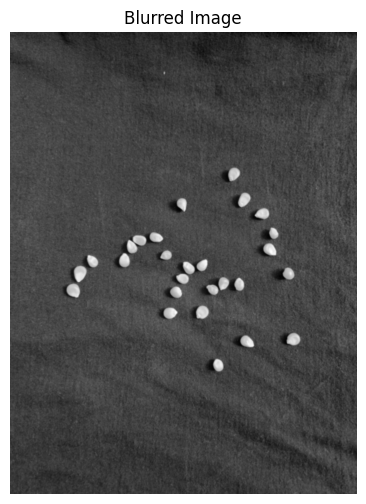

In [54]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
show_image("Blurred Image", blur)

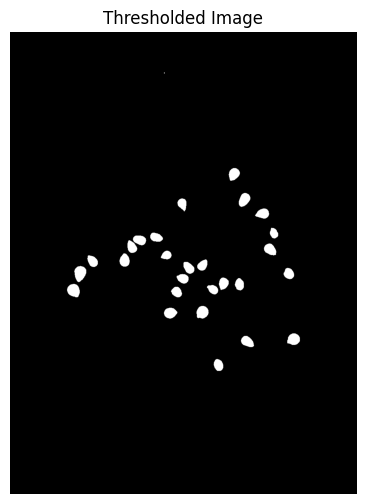

In [55]:
_, thresh = cv2.threshold(blur, 160, 255, cv2.THRESH_BINARY)
show_image("Thresholded Image", thresh)

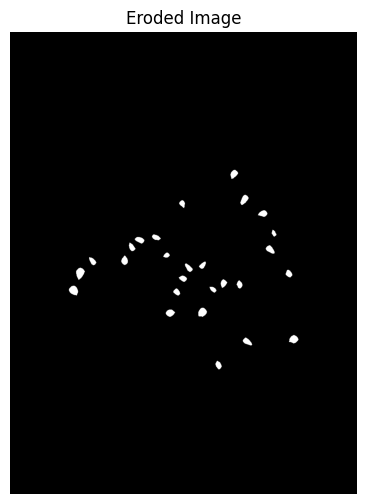

In [56]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
eroded = cv2.erode(thresh, kernel, iterations=1)

show_image("Eroded Image", eroded)

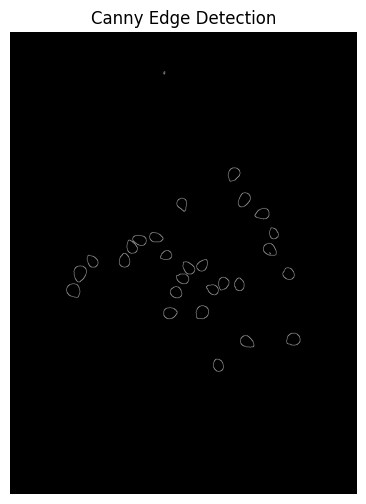

In [57]:
canny1 = cv2.Canny(blur, 160, 200)

show_image("Canny Edge Detection", canny1)

Objetos detectados: 27


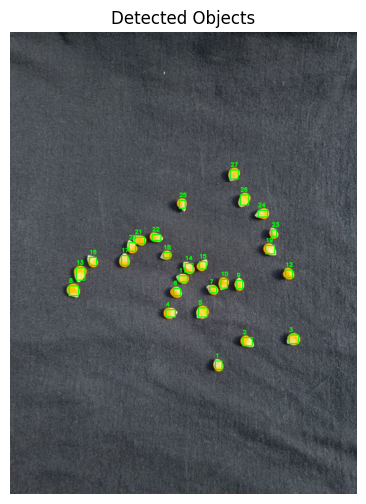

In [58]:
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    cv2.putText(img, f"{i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
print("Objetos detectados:", len(contours))
show_image("Detected Objects", img)

In [59]:
def classify_grain(grain_img, contour_area):
    if contour_area < MIN_AREA:
        return "bad_detection", "area too small (noise)"

    if contour_area > MAX_AREA:
        return "bad_detection", "area too large (probably multiple grains)"

    hsv = cv2.cvtColor(grain_img, cv2.COLOR_BGR2HSV)

    h_mean = np.mean(hsv[:, :, 0])
    s_mean = np.mean(hsv[:, :, 1])
    v_mean = np.mean(hsv[:, :, 2])

    if v_mean < 90 and s_mean < 60:
        return "burned", f"dark grain (H={h_mean:.1f}, S={s_mean:.1f}, V={v_mean:.1f})"

    if 40 <= h_mean <= 80:
        return "greenish", f"green hue (H={h_mean:.1f})"

    if 18 <= h_mean <= 35 and v_mean > 100:
        return "good", f"healthy yellow grain (H={h_mean:.1f})"

    return "unknown", f"undefined color pattern (H={h_mean:.1f})"

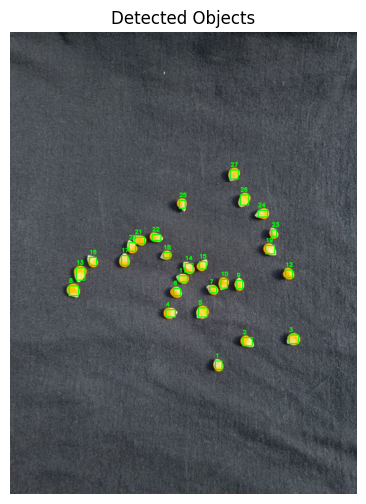

Resumo da classificação dos grãos:
good: 26
burned: 0
greenish: 0
bad_detection: 1
unknown: 0


In [60]:
grains = {
    'good': 0,
    'burned': 0,
    'greenish': 0,
    'bad_detection': 0,
    'unknown': 0
}

for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    grain = craped_img[y:y+h, x:x+w]
    
    hsv = cv2.cvtColor(grain, cv2.COLOR_BGR2HSV)
    h_mean = np.mean(hsv[:, :, 0])
    s_mean = np.mean(hsv[:, :, 1])
    v_mean = np.mean(hsv[:, :, 2])
    area = w * h
    
    classification, reason = classify_grain(grain, area)
    grains[classification] += 1
    # print(f"Objeto {i+1}: x={x}, y={y}, w={w}, h={h}, area={w*h}")
    # print(f"Média HSV: H={h_mean:.2f}, S={s_mean:.2f}, V={v_mean:.2f}")
    # print(f"Classificação: {classification} ({reason})\n")
    # show_image(f"Objeto {i+1}", grain)

show_image("Detected Objects", img)
print("Resumo da classificação dos grãos:")
for category, count in grains.items():
    print(f"{category}: {count}")